## Install packages

In [1]:
# Install pandas for data manipulation and numpy for numerical operations
%pip install pandas numpy matplotlib transformers torch scipy rdkit feature-engine scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


## Import CSV and import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('CycPeptMPDB_Peptide_All.csv', low_memory=False)
print(len(data))

8466


In [3]:
# # Entries with PAMPA scores
# entries_with_pampa = data[data['PAMPA'].notnull()]
# print(f"Entries with PAMPA scores: {len(entries_with_pampa)}")

# # Entries with Caco2 scores
# entries_with_caco2 = data[data['Caco2'].notnull()]
# print(f"Entries with Caco2 scores: {len(entries_with_caco2)}")

# # Entries with both PAMPA and Caco2 scores
# entries_with_both = data[data['PAMPA'].notnull() & data['Caco2'].notnull()]
# print(f"Entries with both PAMPA and Caco2 scores: {len(entries_with_both)}")

## Remove duplicates

In [4]:
# Remove entries with no PAMPA scores
data = data.dropna(subset=['PAMPA'])
print(f"Remaining entries: {len(data)}")

Remaining entries: 7298


In [5]:
data = data.drop_duplicates(subset='Structurally_Unique_ID')
print(len(data))

7229


## Distribution by Source and by Year

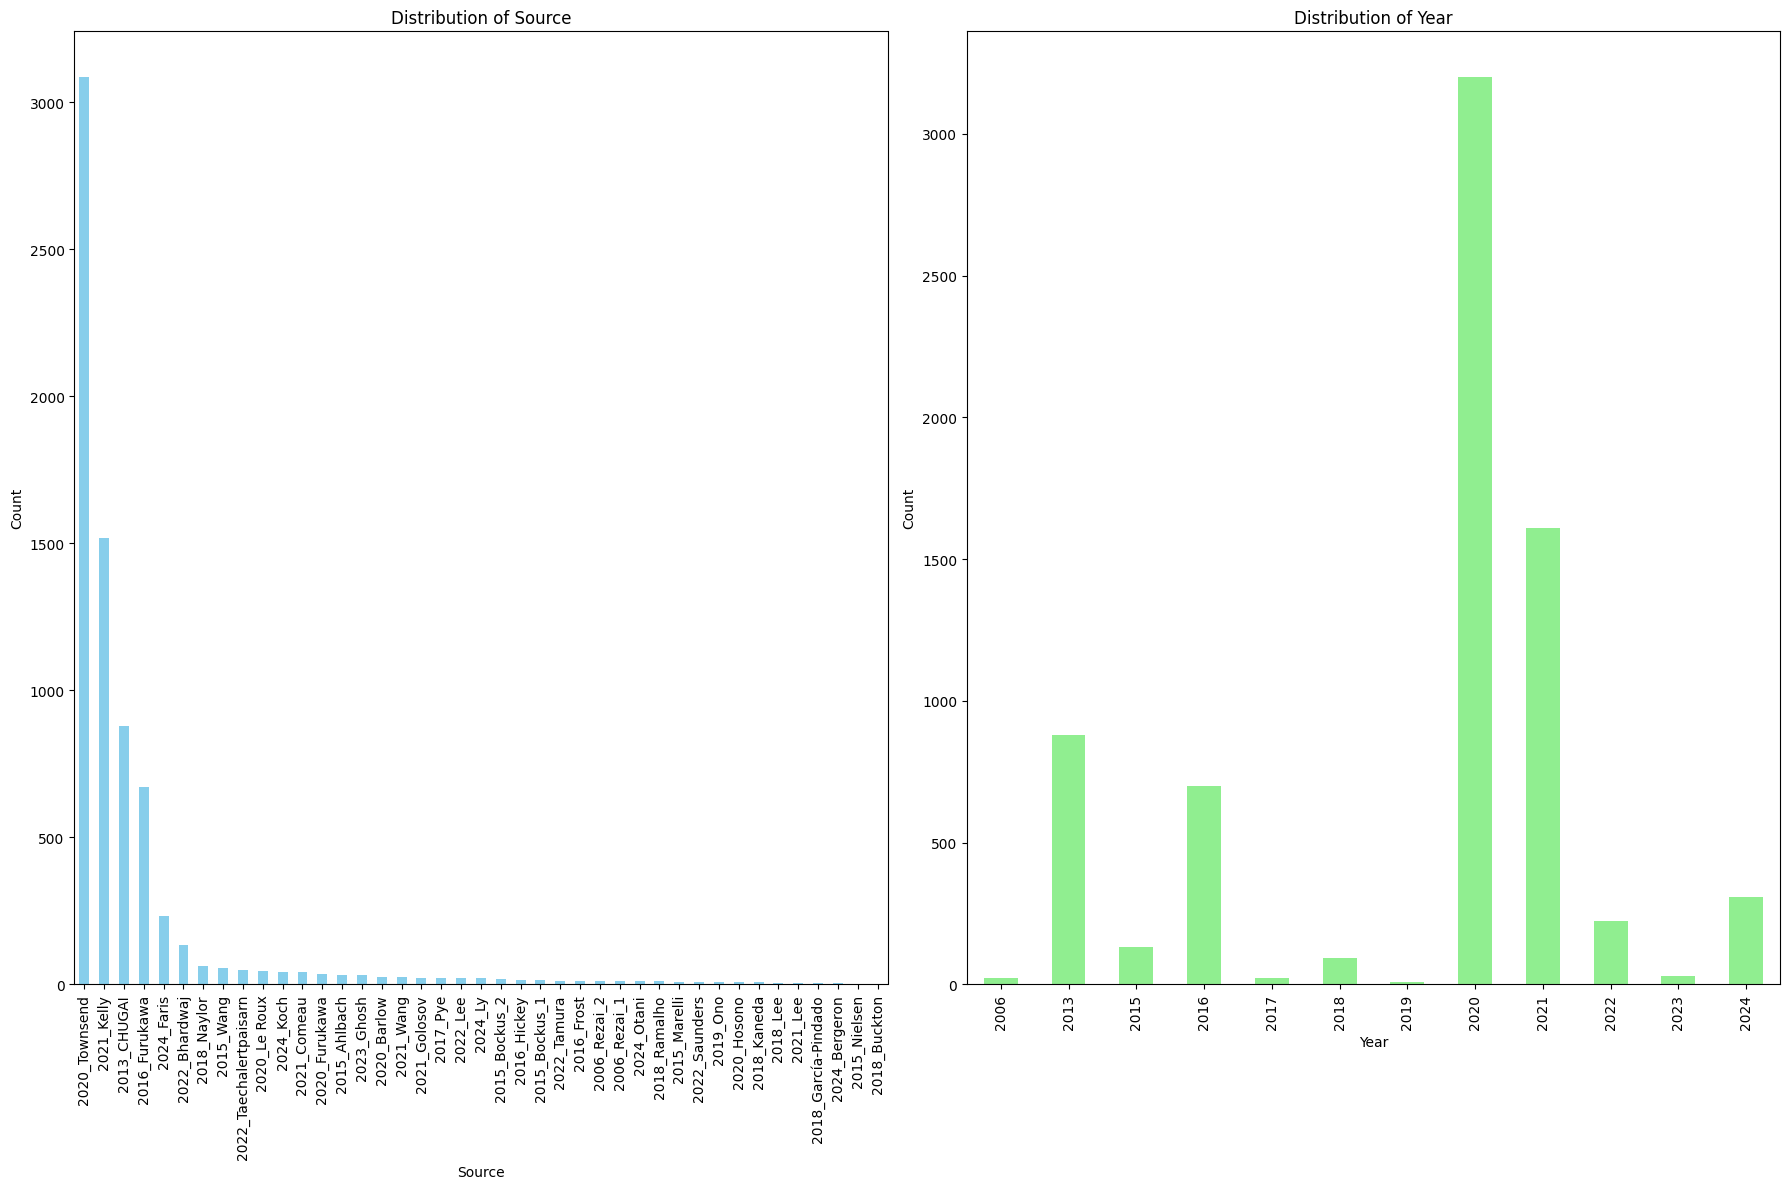

In [6]:
# Create a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# Plot the distribution of the 'Source' column
data['Source'].value_counts().plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Source')
axes[0].set_xlabel('Source')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

# Plot the distribution of the 'Year' column
data['Year'].value_counts().sort_index().plot(kind='bar', color='lightgreen', ax=axes[1])
axes[1].set_title('Distribution of Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()


## Peptide Identity & Sequence Features

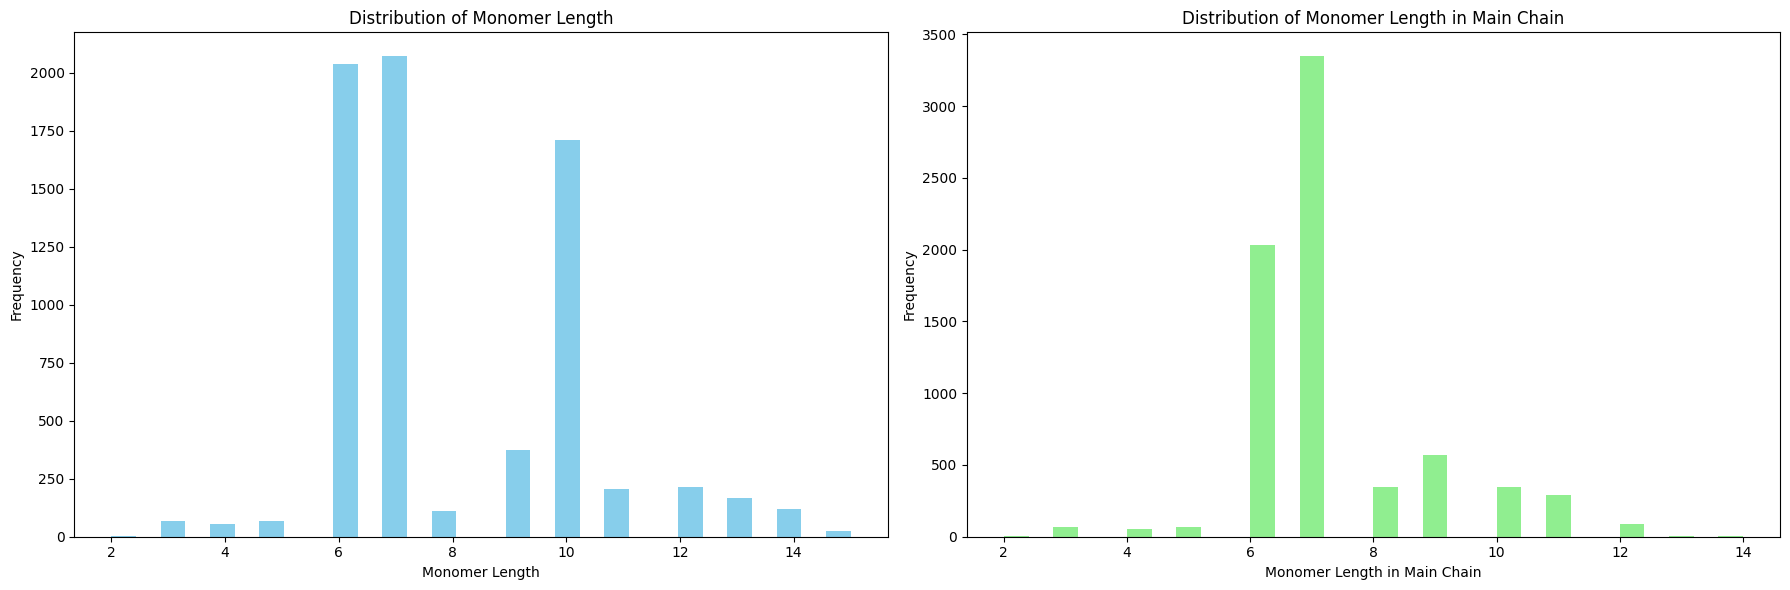

In [7]:
from collections import Counter
import itertools

# Peptide sequence stats
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Length distribution: Monomer_Length
data['Monomer_Length'].plot(kind='hist', bins=30, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Monomer Length')
axes[0].set_xlabel('Monomer Length')
axes[0].set_ylabel('Frequency')

# Length distribution: Monomer_Length_in_Main_Chain
data['Monomer_Length_in_Main_Chain'].plot(kind='hist', bins=30, color='lightgreen', ax=axes[1])
axes[1].set_title('Distribution of Monomer Length in Main Chain')
axes[1].set_xlabel('Monomer Length in Main Chain')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
import ast

# RUN THIS CELL ONLY ONCE
data['Sequence'] = data['Sequence'].apply(ast.literal_eval) # Convert string representation of list to actual list

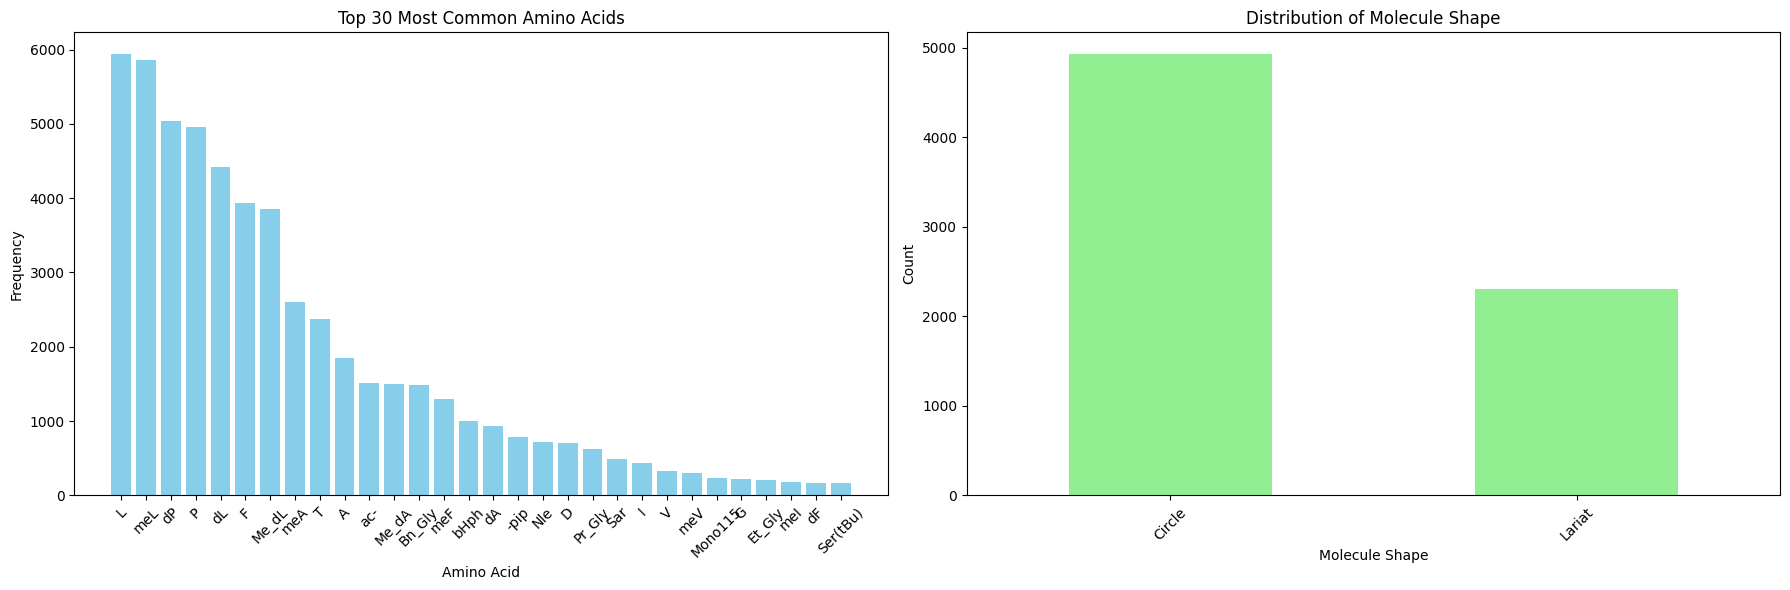

In [9]:
import pandas as pd

# Flatten all amino acids into a single list
all_aas = [aa for seq in data['Sequence'] for aa in seq]

# Count frequency
aa_counts = Counter(all_aas)

# Sort by frequency (descending)
sorted_aa_counts = sorted(aa_counts.items(), key=lambda x: x[1], reverse=True)

# Convert to DataFrame for easy viewing or plotting
aa_freq_df = pd.DataFrame(sorted_aa_counts, columns=["AminoAcid", "Frequency"])

# Plot the top 10 most common amino acids
top_10_aa = aa_freq_df.head(30)

# Create a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the top 30 most common amino acids
axes[0].bar(top_10_aa['AminoAcid'], top_10_aa['Frequency'], color='skyblue')
axes[0].set_title('Top 30 Most Common Amino Acids')
axes[0].set_xlabel('Amino Acid')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Plot the distribution of Molecule_Shape
data['Molecule_Shape'].value_counts().plot(kind='bar', color='lightgreen', ax=axes[1])
axes[1].set_title('Distribution of Molecule Shape')
axes[1].set_xlabel('Molecule Shape')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

## Permeability Annotations

Caco2, MDCK, and RRCK all have the majority annotated as "NaN"

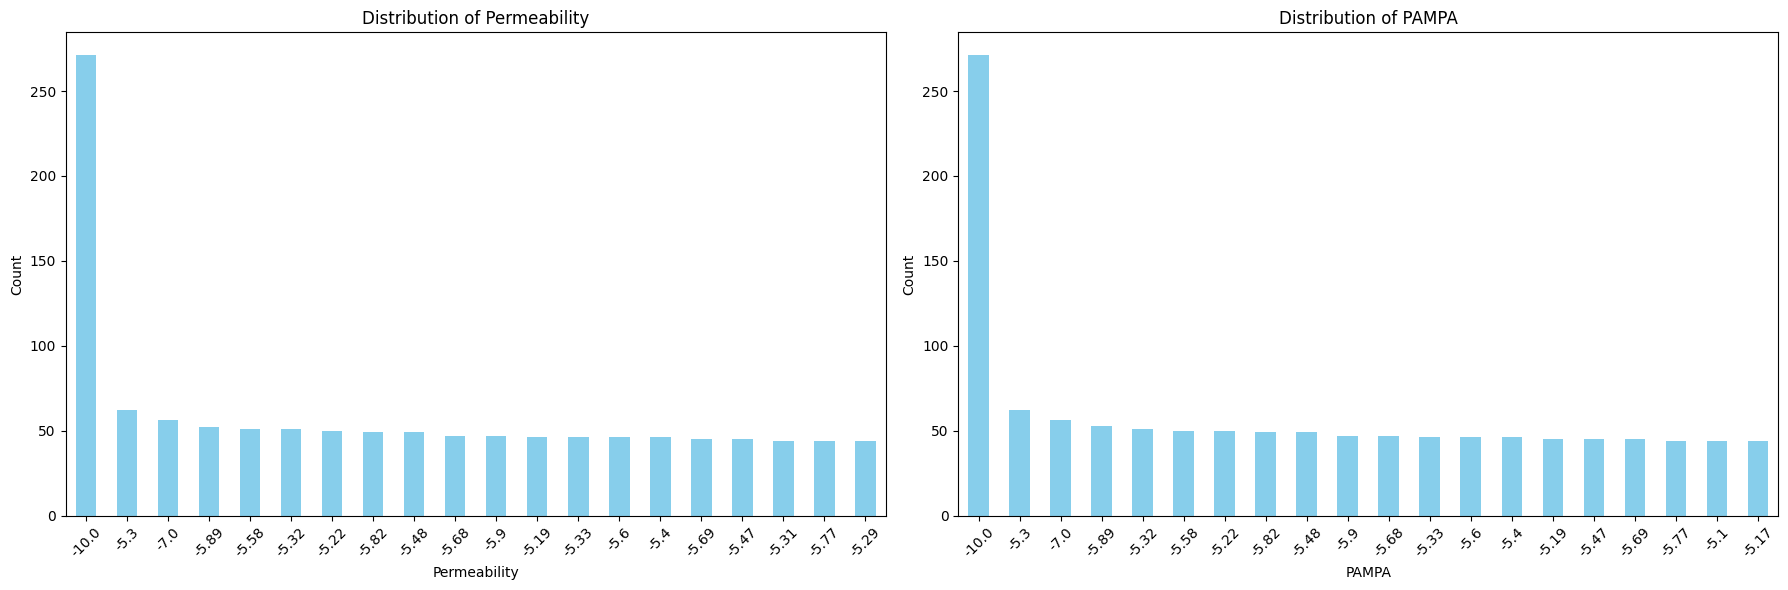

In [10]:
fields_to_plot = ['Permeability', 'PAMPA']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, field in enumerate(fields_to_plot):
    if field in data.columns:
        data[field].value_counts(dropna=False).head(20).plot(kind='bar', ax=axes[i], color='skyblue')
        axes[i].set_title(f'Distribution of {field}')
        axes[i].set_xlabel(field)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


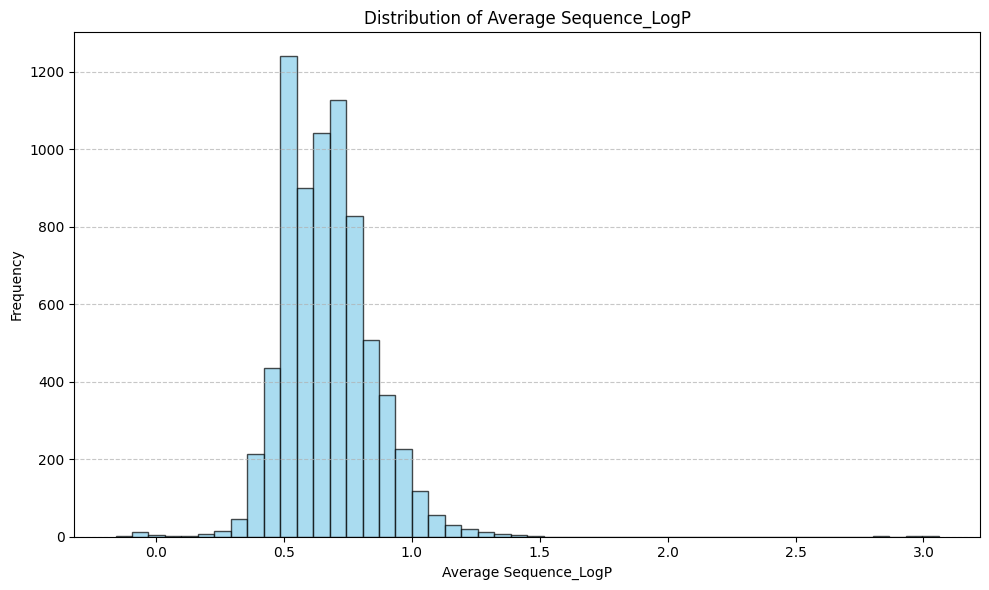

In [11]:
# Plot the distribution of Sequence_LogP
plt.figure(figsize=(10, 6))
data['Sequence_LogP'] = data['Sequence_LogP'].apply(lambda x: list(map(float, x.strip('[]').split(','))) if isinstance(x, str) else x)


# Calculate the average of each list in Sequence_LogP
data['Sequence_LogP_Avg'] = data['Sequence_LogP'].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)

# Plot the histogram of the averages
plt.hist(data['Sequence_LogP_Avg'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Distribution of Average Sequence_LogP')
plt.xlabel('Average Sequence_LogP')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Structure Information

In [12]:
# Check for presence/absence of 3D information
data['Has_3D_Info'] = data['_3DPSA'].notnull()
print(f"Entries with 3D information: {data['Has_3D_Info'].sum()}")
print(f"Entries without 3D information: {len(data) - data['Has_3D_Info'].sum()}")

# Check sequence-structure concordance
sequence_smiles_concordance = data.apply(
    lambda row: row['Sequence'] is not None and row['SMILES'] is not None, axis=1
)
print(f"Entries with both Sequence and SMILES: {sequence_smiles_concordance.sum()}")
print(f"Entries missing either Sequence or SMILES: {len(data) - sequence_smiles_concordance.sum()}")


Entries with 3D information: 11
Entries without 3D information: 7218
Entries with both Sequence and SMILES: 7229
Entries missing either Sequence or SMILES: 0


In [13]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

def get_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors="pt")
    outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1)  # mean pooling
    print(f"Embedding size before flatten: {embedding.shape}")
    return embedding.detach().numpy().flatten()


c:\Users\Jun\Desktop\Files\Coding\active-projects\bsc-thesis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# Example SMILES string
smiles_example = "CC(C)C[C@@H]1NC(=O)[C@@H](CC(C)C)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)[C@@H]2CCCN2C(=O)[C@@H](CC(C)C)NC1=O"

# Get the embedding
embedding = get_embedding(smiles_example)

print(f"Embedding size: {embedding.shape[0]}")

Embedding size before flatten: torch.Size([1, 768])
Embedding size: 768


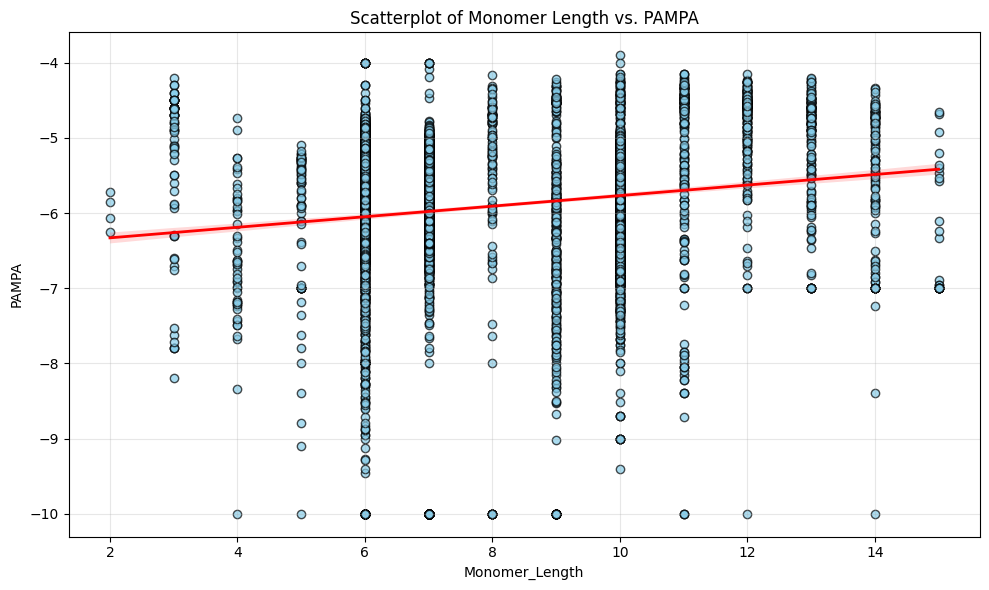

In [15]:
import seaborn as sns

# Scatterplot of Monomer Length vs. PAMPA
plt.figure(figsize=(10, 6))
plt.scatter(data['Monomer_Length'], data['PAMPA'], alpha=0.7, color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Scatterplot of Monomer Length vs. PAMPA')
plt.xlabel('Monomer Length (Number of Residues)')
plt.ylabel('PAMPA')

# Add grid
plt.grid(alpha=0.3)
# Fit a linear trend line using seaborn
sns.regplot(x='Monomer_Length', y='PAMPA', data=data, scatter=False, color='red', line_kws={"linewidth": 2})
# Show plot
plt.tight_layout()


# Show plot
plt.show()

Number of rows where PAMPA is equal to -10: 271
Remaining entries after removing -10 PAMPA: 6958


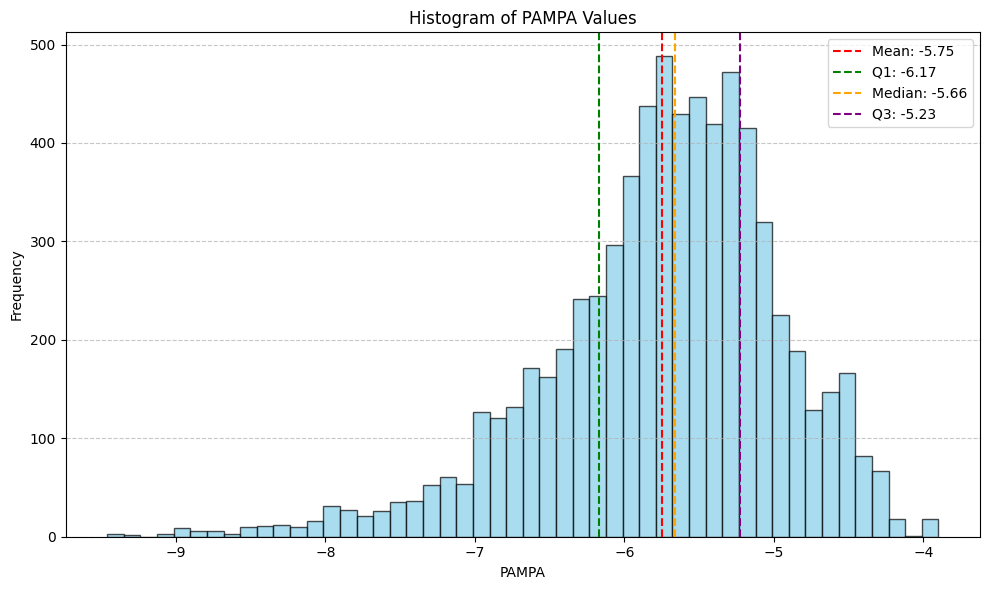

In [16]:
# Ensure PAMPA values are numeric
data['PAMPA'] = pd.to_numeric(data['PAMPA'])

# Drop all rows where PAMPA is equal to -10
print(f"Number of rows where PAMPA is equal to -10: {data[data['PAMPA'] == -10].shape[0]}")
data = data[data['PAMPA'] != -10]
print(f"Remaining entries after removing -10 PAMPA: {len(data)}")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data['PAMPA'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)

# Calculate statistics
mean_pampa = data['PAMPA'].mean()
q1_pampa = data['PAMPA'].quantile(0.25)
median_pampa = data['PAMPA'].median()
q3_pampa = data['PAMPA'].quantile(0.75)

# Overlay mean and quartiles
plt.axvline(mean_pampa, color='red', linestyle='--', label=f'Mean: {mean_pampa:.2f}')
plt.axvline(q1_pampa, color='green', linestyle='--', label=f'Q1: {q1_pampa:.2f}')
plt.axvline(median_pampa, color='orange', linestyle='--', label=f'Median: {median_pampa:.2f}')
plt.axvline(q3_pampa, color='purple', linestyle='--', label=f'Q3: {q3_pampa:.2f}')

# Add labels, title, and legend
plt.title('Histogram of PAMPA Values')
plt.xlabel('PAMPA')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Statistical Analysis of Different Molecular Shapes

These cells collectively aim to:
1. Visualize the relationship and distribution of `PAMPA` values for different molecular shapes.
2. Perform statistical analysis to identify differences in `PAMPA` values between "Circle" and "Lariat" shapes.

Lowest PAMPA value for each group:
Data length: 6958
Molecule_Shape
Circle   -9.46
Lariat   -9.00
Name: PAMPA, dtype: float64


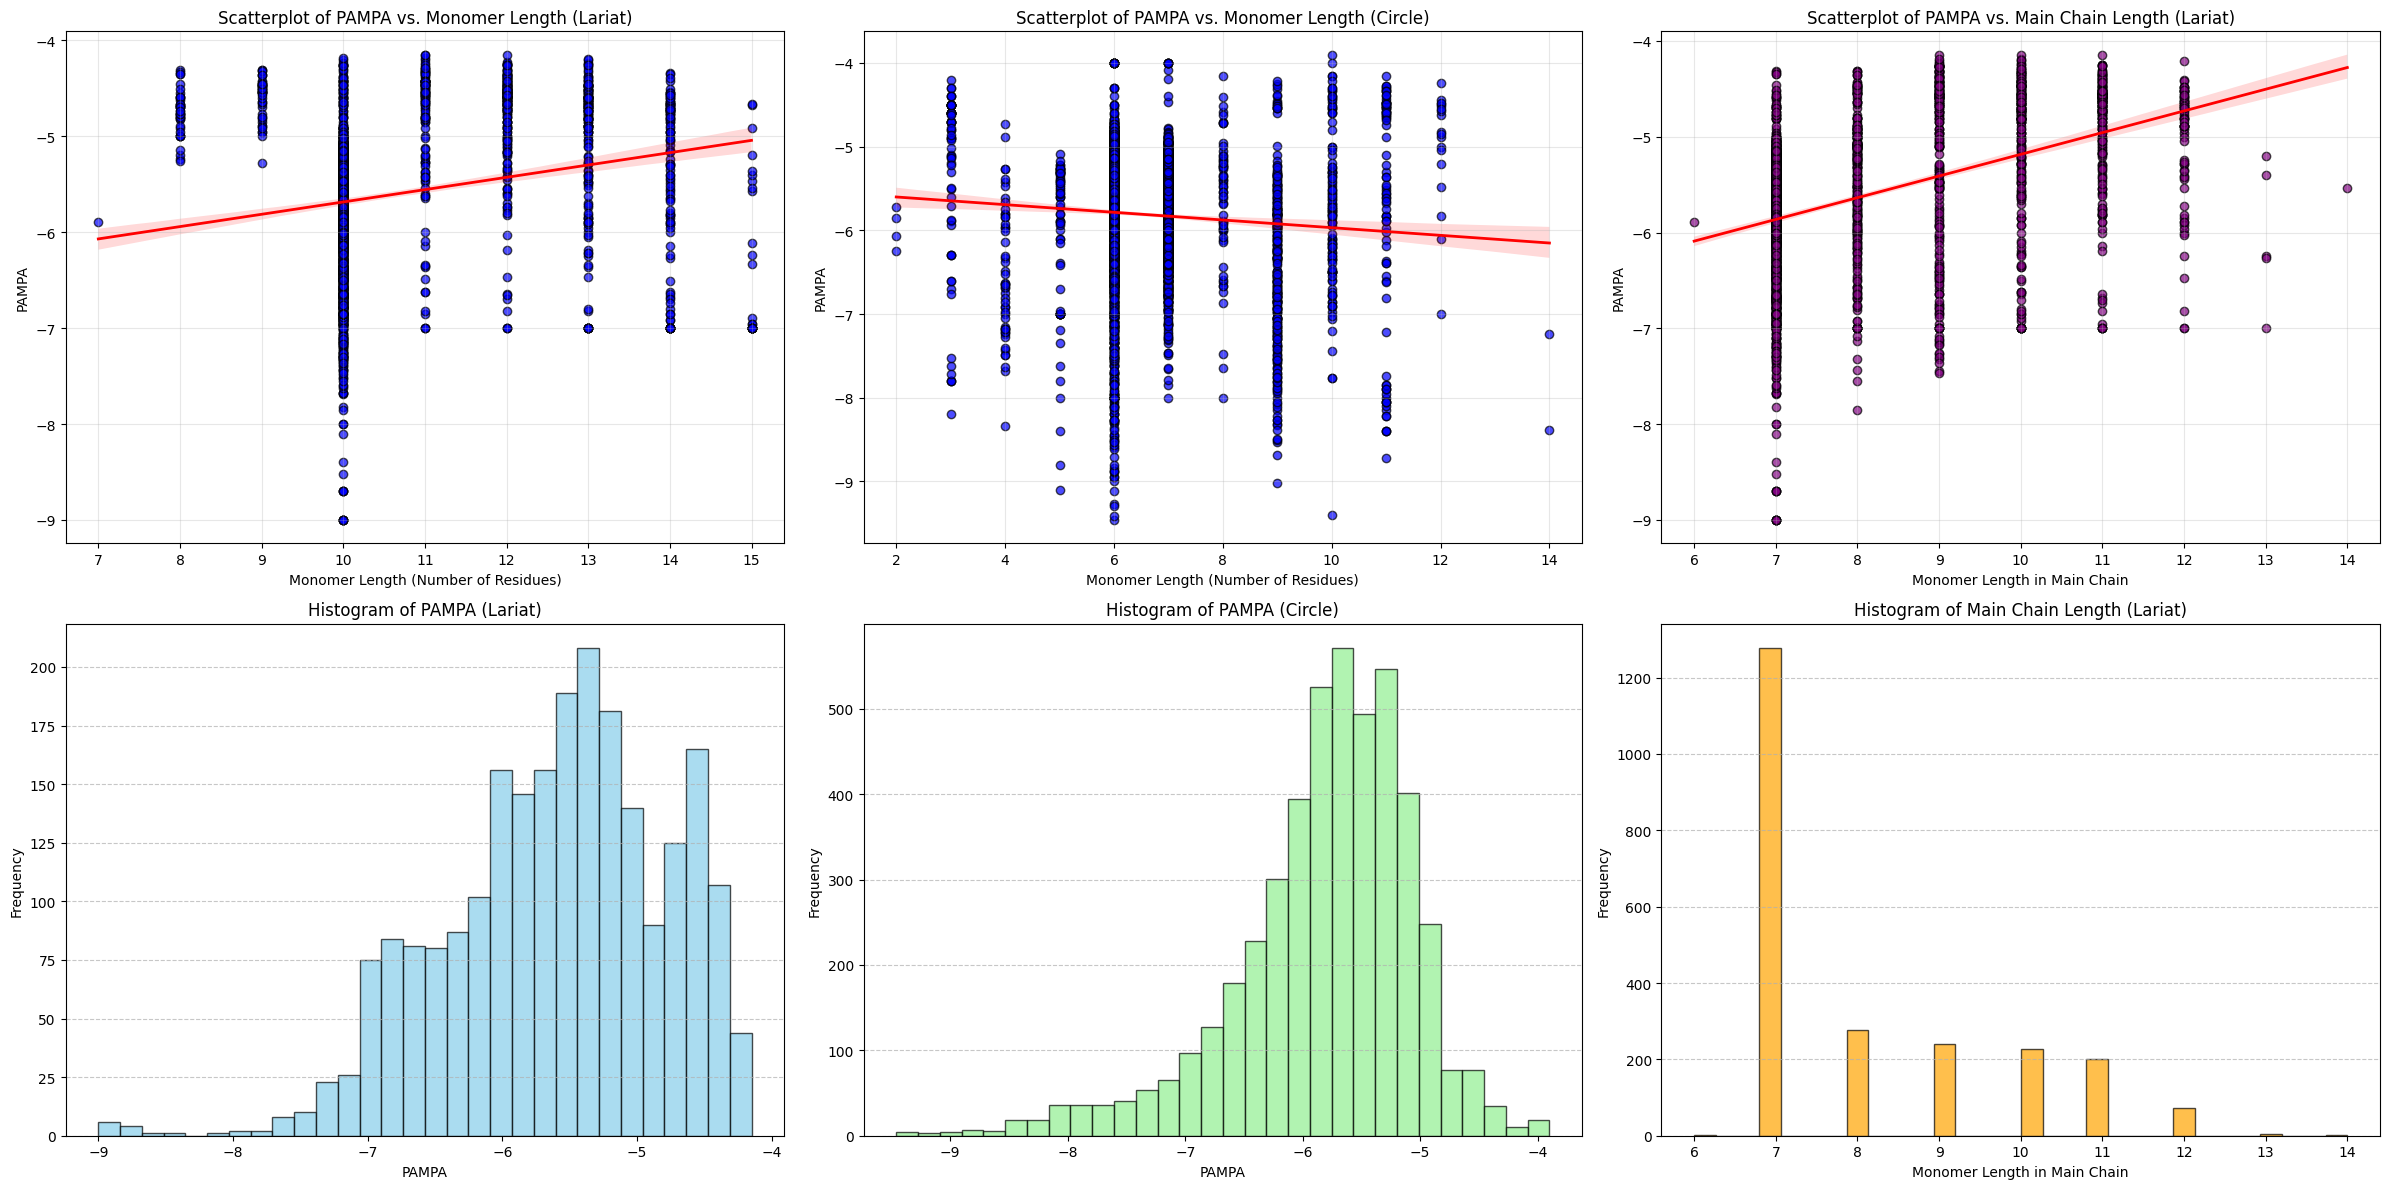

In [17]:
# Create a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
# Group data by Molecule_Shape and find the lowest PAMPA value for each group
lowest_pampa_per_group = data.groupby('Molecule_Shape')['PAMPA'].min()
print("Lowest PAMPA value for each group:")
print(f"Data length: {len(data)}")
print(lowest_pampa_per_group)
# Filter data for Lariat and Circle shapes
lariat_data = data[data['Molecule_Shape'] == 'Lariat']
circle_data = data[data['Molecule_Shape'] == 'Circle']

# Scatterplot of PAMPA vs. Monomer Length for Lariat shape
axes[0, 0].scatter(lariat_data['Monomer_Length'], lariat_data['PAMPA'], alpha=0.7, color='blue', edgecolor='black')
sns.regplot(x='Monomer_Length', y='PAMPA', data=lariat_data, scatter=False, color='red', ax=axes[0, 0], line_kws={"linewidth": 2})
axes[0, 0].set_title('Scatterplot of PAMPA vs. Monomer Length (Lariat)')
axes[0, 0].set_xlabel('Monomer Length (Number of Residues)')
axes[0, 0].set_ylabel('PAMPA')
axes[0, 0].grid(alpha=0.3)

# Scatterplot of PAMPA vs. Monomer Length for Circle shape
axes[0, 1].scatter(circle_data['Monomer_Length'], circle_data['PAMPA'], alpha=0.7, color='blue', edgecolor='black')
sns.regplot(x='Monomer_Length', y='PAMPA', data=circle_data, scatter=False, color='red', ax=axes[0, 1], line_kws={"linewidth": 2})
axes[0, 1].set_title('Scatterplot of PAMPA vs. Monomer Length (Circle)')
axes[0, 1].set_xlabel('Monomer Length (Number of Residues)')
axes[0, 1].set_ylabel('PAMPA')
axes[0, 1].grid(alpha=0.3)

# Histogram of PAMPA values for Lariat shape
axes[1, 0].hist(lariat_data['PAMPA'].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Histogram of PAMPA (Lariat)')
axes[1, 0].set_xlabel('PAMPA')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Histogram of PAMPA values for Circle shape
axes[1, 1].hist(circle_data['PAMPA'].dropna(), bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Histogram of PAMPA (Circle)')
axes[1, 1].set_xlabel('PAMPA')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Histogram of Monomer Length in Main Chain for Lariat shape
axes[1, 2].hist(lariat_data['Monomer_Length_in_Main_Chain'].dropna(), bins=30, color='orange', edgecolor='black', alpha=0.7)
sns.regplot(x='Monomer_Length_in_Main_Chain', y='PAMPA', data=lariat_data, scatter=False, color='red', ax=axes[0, 2], line_kws={"linewidth": 2})
axes[1, 2].set_title('Histogram of Main Chain Length (Lariat)')
axes[1, 2].set_xlabel('Monomer Length in Main Chain')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].grid(axis='y', linestyle='--', alpha=0.7)

# Scatterplot of PAMPA vs. Monomer Length in Main Chain for Lariat shape
axes[0, 2].scatter(lariat_data['Monomer_Length_in_Main_Chain'], lariat_data['PAMPA'], alpha=0.7, color='purple', edgecolor='black')
axes[0, 2].set_title('Scatterplot of PAMPA vs. Main Chain Length (Lariat)')
axes[0, 2].set_xlabel('Monomer Length in Main Chain')
axes[0, 2].set_ylabel('PAMPA')
axes[0, 2].grid(alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()


In [18]:
from scipy.stats import shapiro, levene

# Filter PAMPA values for Circle and Lariat shapes
pampa_circle = data[data['Molecule_Shape'] == 'Circle']['PAMPA']
pampa_lariat = data[data['Molecule_Shape'] == 'Lariat']['PAMPA']

# Shapiro–Wilk test for normality
shapiro_cyclic = shapiro(pampa_circle)
shapiro_lariat = shapiro(pampa_lariat)

print(f"Shapiro–Wilk test for cyclic peptides: W={shapiro_cyclic.statistic}, p={shapiro_cyclic.pvalue}")
print(f"Shapiro–Wilk test for lariat peptides: W={shapiro_lariat.statistic}, p={shapiro_lariat.pvalue}")

# Levene's test for homogeneity of variance
levene_test = levene(pampa_circle, pampa_lariat)
print(f"Levene's test: W={levene_test.statistic}, p={levene_test.pvalue}")



Shapiro–Wilk test for cyclic peptides: W=0.9414828477184046, p=1.6917304816724265e-39
Shapiro–Wilk test for lariat peptides: W=0.9697146522677176, p=1.262216356649899e-21
Levene's test: W=42.26473411120315, p=8.523608031812497e-11


In [19]:
from scipy.stats import mannwhitneyu

# Perform the Mann-Whitney U test
mannwhitney_result = mannwhitneyu(pampa_circle, pampa_lariat, alternative='two-sided')

# Print the results
print(f"Mann-Whitney U test statistic: {mannwhitney_result.statistic}")
print(f"P-value: {mannwhitney_result.pvalue}")

Mann-Whitney U test statistic: 4538808.0
P-value: 3.169594625117628e-25


### Classical Model Preprocessing


In [20]:
# Drop columns with any empty rows
features = data.dropna(axis=1)

print(f"Remaining columns after dropping features with empty rows or majority zeros: {features.shape[1]}")

Remaining columns after dropping features with empty rows or majority zeros: 229


In [21]:
from feature_engine.selection import DropConstantFeatures

# Define columns to exclude (identifying information and previously dropped columns)
exclude_columns = [
    'ID', 'Source', 'Year', 'Version', 'Original_Name_in_Source_Literature',
    'Structurally_Unique_ID', 'SMILES', 'HELM', 'HELM_URL', 'Sequence'
]

# Drop identifying variables
features = features.drop(columns=[col for col in exclude_columns if col in features.columns])

print(f"Remaining features after dropping identifying variables: {features.shape[1]}")

# Drop near zero variance variables
constant_feature_dropper = DropConstantFeatures(tol=0.9)
features = constant_feature_dropper.fit_transform(features)

print(f"Remaining features after dropping near zero variance variables: {features.shape[1]}")

Remaining features after dropping identifying variables: 219
Remaining features after dropping near zero variance variables: 125


In [22]:
from feature_engine.selection import DropCorrelatedFeatures

# Initialize the transformer with a correlation threshold
correlation_threshold = 0.9
correlated_feature_dropper = DropCorrelatedFeatures(variables=None, method="pearson", threshold=correlation_threshold)

# Fit and transform the features
features = correlated_feature_dropper.fit_transform(features)

# Print the remaining features
print(f"Remaining features after dropping correlated features: {features.shape[1]}")
print(f"Columns after processing: {features.columns.tolist()}")

Remaining features after dropping correlated features: 53
Columns after processing: ['Sequence_LogP', 'Sequence_TPSA', 'Monomer_Length_in_Main_Chain', 'Molecule_Shape', 'PAMPA', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MaxPartialCharge', 'MaxAbsPartialCharge', 'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Ipc', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA3', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA4', 'SMR_VSA6', 'EState_VSA8', 'EState_VSA9', 'VSA_EState3', 'VSA_EState4', 'VSA_EState7', 'FractionCSP3', 'NHOHCount', 'NumAliphaticHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP', 'fr_Al_OH', 'fr_NH0', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_bicyclic', 'fr_ether', 'fr_lactone', 'fr_piperdine', 'PC2', 'Sequence_LogP_Avg']


In [23]:
# Separate the target variable (PAMPA) from the feature matrix
y = features['PAMPA']
features = features.drop(columns=['PAMPA'])

print(f"Shape of features after dropping PAMPA: {features.shape}")
print(f"Shape of target variable y: {y.shape}")


Shape of features after dropping PAMPA: (6958, 52)
Shape of target variable y: (6958,)


In [24]:
from feature_engine.encoding import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(variables=['Molecule_Shape'], drop_last=True)

# Fit and transform the features
encoded_features = encoder.fit_transform(features)

print(f"Shape of features after one-hot encoding: {encoded_features.shape}")
print(f"Columns after encoding: {encoded_features.columns.tolist()}")

Shape of features after one-hot encoding: (6958, 52)
Columns after encoding: ['Sequence_LogP', 'Sequence_TPSA', 'Monomer_Length_in_Main_Chain', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MaxPartialCharge', 'MaxAbsPartialCharge', 'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Ipc', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA3', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA4', 'SMR_VSA6', 'EState_VSA8', 'EState_VSA9', 'VSA_EState3', 'VSA_EState4', 'VSA_EState7', 'FractionCSP3', 'NHOHCount', 'NumAliphaticHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP', 'fr_Al_OH', 'fr_NH0', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_bicyclic', 'fr_ether', 'fr_lactone', 'fr_piperdine', 'PC2', 'Sequence_LogP_Avg', 'Molecule_Shape_Circle']


In [25]:
features = encoded_features.drop(columns=['Sequence_LogP', 'PC2'])

print(f"Remaining features after dropping 'Sequence_LogP' and 'PC2': {features.shape[1]}") 

Remaining features after dropping 'Sequence_LogP' and 'PC2': 50


In [26]:
# Convert the Sequence_TPSA column from string to list of floats
features['Sequence_TPSA'] = features['Sequence_TPSA'].apply(lambda x: list(map(float, x.strip('[]').split(','))) if isinstance(x, str) else x)

# Calculate the required statistics and create new columns
features['Sequence_TPSA_Mean'] = features['Sequence_TPSA'].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)
features['Sequence_TPSA_Median'] = features['Sequence_TPSA'].apply(lambda x: np.median(x) if isinstance(x, list) else np.nan)
features['Sequence_TPSA_Std'] = features['Sequence_TPSA'].apply(lambda x: np.std(x) if isinstance(x, list) else np.nan)
features['Sequence_TPSA_Min'] = features['Sequence_TPSA'].apply(lambda x: np.min(x) if isinstance(x, list) else np.nan)
features['Sequence_TPSA_Max'] = features['Sequence_TPSA'].apply(lambda x: np.max(x) if isinstance(x, list) else np.nan)

# Drop the original Sequence_TPSA column
features = features.drop(columns=['Sequence_TPSA'])

print(features.head())

   Monomer_Length_in_Main_Chain  MaxAbsEStateIndex  MinAbsEStateIndex  \
0                            11          18.025327           3.146714   
1                             6          16.312544           1.737067   
2                             6          16.312544           1.737067   
3                             6          16.312544           1.737067   
4                             6          16.312544           1.737067   

        qed  MaxPartialCharge  MaxAbsPartialCharge  FpDensityMorgan1  \
0  0.147925          0.245644             0.390126          0.564706   
1  0.215270          0.293092             0.507967          0.745098   
2  0.215270          0.293092             0.507967          0.745098   
3  0.215270          0.293092             0.507967          0.745098   
4  0.215270          0.293092             0.507967          0.745098   

    BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  ...  fr_ether  fr_lactone  \
0  1.150000e-16     -0.249288 -3.720000e-16  ...      

In [27]:
def check_data_issues(features):
    """
    Check for NaN, infinite, and out-of-range values in a DataFrame.

    Parameters:
    features (pd.DataFrame): The DataFrame to check.

    Returns:
    dict: A dictionary containing counts of NaN, infinite, and out-of-range values,
          as well as a list of columns with issues.
    """
    # Check for NaN values
    nan_count = features.isna().sum().sum()
    print(f"Number of NaN values: {nan_count}")

    # Check for infinite values
    inf_count = np.isinf(features).sum().sum()
    print(f"Number of infinite values: {inf_count}")

    # Check for values that would exceed float32 range
    float32_min = np.finfo(np.float32).min
    float32_max = np.finfo(np.float32).max
    exceed_float32 = features[(features < float32_min) | (features > float32_max)].count().sum()
    print(f"Number of values exceeding float32 range: {exceed_float32}")

    # List columns with NaN, infinite, or out-of-range values
    columns_with_issues = features.columns[
        features.isna().any() | np.isinf(features).any() | 
        ((features < float32_min) | (features > float32_max)).any()
    ]
    print(f"Columns with issues: {columns_with_issues.tolist()}")

    return {
        "nan_count": nan_count,
        "inf_count": inf_count,
        "exceed_float32": exceed_float32,
        "columns_with_issues": columns_with_issues.tolist()
    }
    
# Check for data issues
data_issues = check_data_issues(features)
print(f"Data issues: {data_issues}")


Number of NaN values: 0
Number of infinite values: 0
Number of values exceeding float32 range: 4841
Columns with issues: ['Ipc']
Data issues: {'nan_count': np.int64(0), 'inf_count': np.int64(0), 'exceed_float32': np.int64(4841), 'columns_with_issues': ['Ipc']}


In [28]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the 'Ipc' column
features['Ipc_Normalized'] = scaler.fit_transform(features[['Ipc']])

# Drop the original 'Ipc' column
features = features.drop(columns=['Ipc'])

print(features.head())

   Monomer_Length_in_Main_Chain  MaxAbsEStateIndex  MinAbsEStateIndex  \
0                            11          18.025327           3.146714   
1                             6          16.312544           1.737067   
2                             6          16.312544           1.737067   
3                             6          16.312544           1.737067   
4                             6          16.312544           1.737067   

        qed  MaxPartialCharge  MaxAbsPartialCharge  FpDensityMorgan1  \
0  0.147925          0.245644             0.390126          0.564706   
1  0.215270          0.293092             0.507967          0.745098   
2  0.215270          0.293092             0.507967          0.745098   
3  0.215270          0.293092             0.507967          0.745098   
4  0.215270          0.293092             0.507967          0.745098   

    BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  ...  fr_lactone  fr_piperdine  \
0  1.150000e-16     -0.249288 -3.720000e-16  ...  

In [29]:
features.to_csv('features.csv', index=False)

### Train the Model

In [30]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 5566
Test set size: 1392


In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

Root Mean Squared Error: 0.4881
Mean Absolute Error: 0.3538
R-squared: 0.6346
